#  Introduction

The phenotype of a cell refers to its profile of gene expression.  In a multicellular organism, what differentiates cells of one type from another are their phenotypes.  The phenotype of a cell is often described by which genes are highly expressed and which genes are not.  This is how cell-types are refined into subtypes, ad infinitum.  For example, within the CD8 T-cells, the expression of CD62L (L-selectin), CCR7, CD45RA, and CD45RO separates the central memory, effector memory, stem cell memory, and effector types according to [Golubovskaya and Wu](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4810120/), for example.  Others use different sets of genes to identify subtypes of cells, though most seek to align phenotypic categories with knowledge of function.

Here we challenge this phenotypic classification in two ways. One is a challenge to the gene-by-gene binary approach which underlies most classification schemes.  The other is a challenge to the endless divisions into subtypes.  

## Linear classifiers and the single cell

Imagine that we classify cells by the expression of two genes -- call them ABC and XYZ.  Some cells (P-type, let's call them) tend to express both genes ABC and XYZ, while others (N-type) tend not to express them.  At least that is the evidence from bulk RNA study.  If we look at single-cell RNA study, it seems that P-type cells express gene ABC 80% of the time and XYZ 70% of the time, while N-type cells express gene ABC 10% of the time and XYZ 20% of the time.  When the genes are not expressed, this appears as a "dropout" in the single-cell RNA data.  When the genes are expressed, let's say they are expressed at an average level of 5 with standard deviation 1.  When the genes are not expressed, let's say that some technical noise expresses them at an average level of 0.6 with standard deviation 0.3. 

We begin with a simulation of this, with 1000 P-type cells and 1000 N-type cells.

In [1]:
import numpy as np  
import pandas as pd 
from itertools import chain, compress # Nice way to apply masks to lists, etc.

cell_array = np.random.normal(loc=5, scale=1, size=(2000,2))
cell_array[:1000, 0] = cell_array[:1000, 0] * np.random.choice([0,1], 1000, p=[0.2,0.8])
cell_array[:1000, 1] = cell_array[:1000, 1] * np.random.choice([0,1], 1000, p=[0.3,0.7])
cell_array[1000:, 0] = cell_array[1000:, 0] * np.random.choice([0,1], 1000, p=[0.9,0.1])
cell_array[1000:, 1] = cell_array[1000:, 1] * np.random.choice([0,1], 1000, p=[0.8,0.2])
cell_array = cell_array + np.random.normal(loc=0.6, scale=0.3, size=(2000,2))

cellnames = ['Pcell' + str(n) for n in range(1000)] + ['Ncell'+str(n) for n in range(1000)]
bulkgroups = list( chain.from_iterable( [ ['Bulk'+str(n)] * 20 for n in range(100) ] ))
df = pd.DataFrame(cell_array, columns = ['ABC', 'XYZ'], index=cellnames)
df['bulkgroup'] = bulkgroups
df['type'] = ['P']*1000 + ['N']*1000
df.head()

,ABC,XYZ,bulkgroup,type
Pcell0,3.736248,7.734578,Bulk0,P
Pcell1,6.858142,0.990839,Bulk0,P
Pcell2,3.238894,4.897884,Bulk0,P
Pcell3,5.153863,4.970953,Bulk0,P
Pcell4,5.463992,5.482289,Bulk0,P


If we only work with bulk RNA data, we might only see the average (or total) gene expression for bulks of 20 or more cells.  We might only see the following.

In [2]:
bulk_df = df.groupby(['bulkgroup', 'type']).apply(np.mean).reset_index('type')
bulk_df.head()

,type,ABC,XYZ
bulkgroup,,,
Bulk0,P,4.492955,4.950335
Bulk1,P,4.924138,4.113674
Bulk10,P,5.101587,3.175247
Bulk11,P,3.750680,3.439890
Bulk12,P,4.573723,3.427690


If we produce a scatterplot of the gene expression for these bulks, we see how the two cell types are separated.

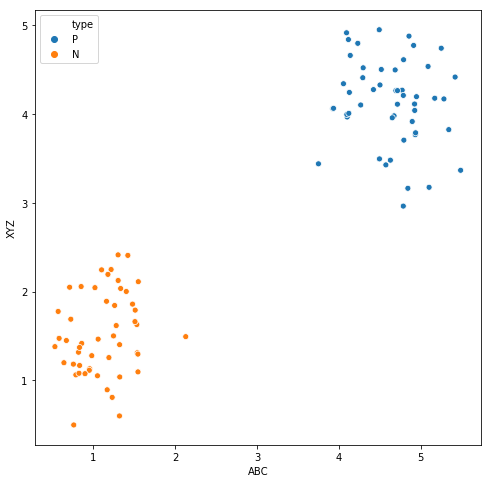

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Put plots inline rather than in a pop-up.
%matplotlib inline

plt.figure(figsize=(8,8))

sns.scatterplot(x='ABC', y='XYZ', data=bulk_df, hue='type')

This kind of data might lead us to classify some cells as $ABC^+XYZ^+$ and others as $ABC^-XYZ^-$.  The first group is characterized by "high" expression of both ABC and XYZ.  The second by "low" expression of both ABC and XYZ.  Effectively we are drawing a horizontal and vertical line on the above scatterplot, and declaring cells in the top-right quadrant to be one type and those in the bottom-left quadrant to be another.

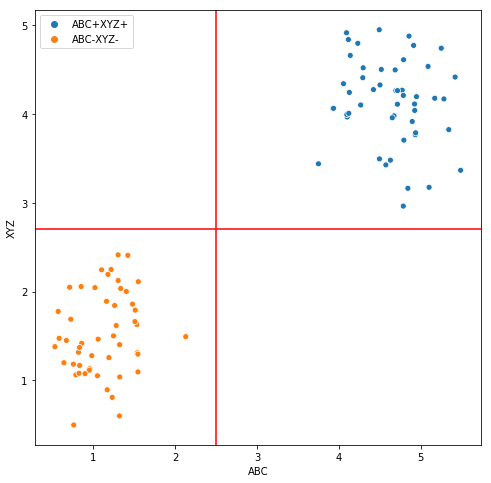

In [4]:
plt.figure(figsize=(8,8))
newtypes = ['ABC+XYZ+' if t == 'P'
           else 'ABC-XYZ-'
           for t in bulk_df.type]

sns.scatterplot(x='ABC', y='XYZ', data=bulk_df, hue=newtypes)
plt.axvline(x=2.5, c='r')
plt.axhline(y=2.7, c='r')

From the standpoint of bulk RNA data, we see that this kind of phenotype is a very effective way to recover the cell classification.  A horizontal and vertical line suffice to separate the two classes of cells, with just an occasional unclassified outliers.  This kind of bulk RNA analysis supports a classical gene+/gene- kind of phenotype.

But notice that the pair of lines is less effective as a classifier than a single (well-chosen) diagonal line.  

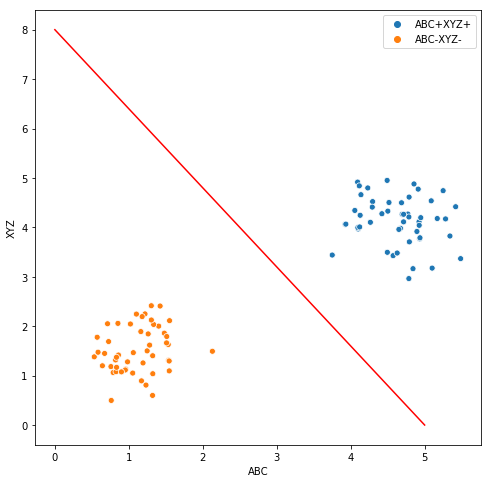

In [8]:
plt.figure(figsize=(8,8))
newtypes = ['ABC+XYZ+' if t == 'P'
           else 'ABC-XYZ-'
           for t in bulk_df.type]

sns.scatterplot(x='ABC', y='XYZ', data=bulk_df, hue=newtypes)
plt.plot([0,5], [8,0], 'r-')

Now let's see how this sort of classification works for the single-cell data.  The underlying data is exactly the same -- we're just looking at single cells rather than 20-cell bulks.

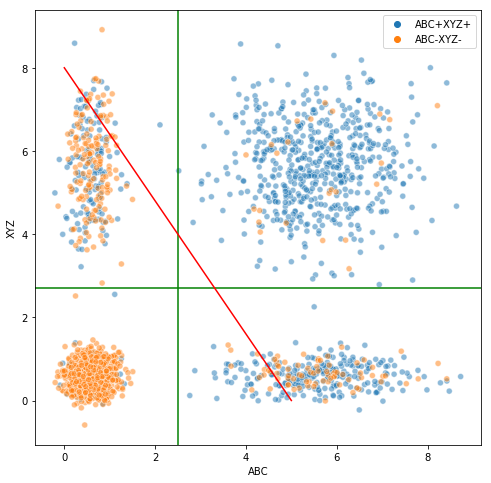

In [9]:
plt.figure(figsize=(8,8))
newtypes = ['ABC+XYZ+' if t == 'P'
           else 'ABC-XYZ-'
           for t in df.type]

sns.scatterplot(x='ABC', y='XYZ', data=df, alpha=0.5, hue=newtypes)
plt.axvline(x=2.5, c='g')
plt.axhline(y=2.7, c='g')
plt.plot([0,5], [8,0], 'r-')

In this single-cell data, misclassification is inevitable.  Moreover, the horizontal and vertical lines (green here) cannot be used in the same way as for the bulks.  The cells previously classified as $ABC^-XYZ^-$ sometimes lie in the bottom-left quadrant.  But often they occupy the top-left and bottom-right quadrants (and occasionally top-right).  So does one call these cells $ABC^-XYZ^+$ or $ABC^+XYZ^-$ types now?  Does the single-cell data suggest that we should add more subtypes into our classification corresponding to the top-left and bottom-right quadrants?

Absolutely not!  The data was created as a simulation of two cell-types, so we should certainly not create new divisions resulting in four cell-types!  The plot above seems to have four "blobs" of cells, but there are only two types.

The red diagonal line is a better classifier.  It separates the cells into two types with pretty high accuracy.

In [10]:
df['line_class'] = df['XYZ'] > 8.0 - 1.6*df['ABC']
Pacc = len(df[(df['type']=='P') & (df['line_class'])])
Nacc = len(df[(df['type']=='N') & (~df['line_class'])])
print('Accuracy of linear classifier: {0:1.2%}'.format((Pacc+Nacc)/2000))

Accuracy of linear classifier: 83.20%


The line we have drawn in our classifier has equation $y = 8 - 1.6 x$, where gene XYZ is plotted on the y-axis and gene ABC is plotted on the x-axis.  Or equivalently, the equation is $8x + 5y = 40$.  In this form, the coefficients reflect the relative important of the genes in classification.  The coefficient of $x$ is larger, reflecting the fact that gene ABC has more power to discriminate the two cell types.  In this way, the linear classifier carries information beyond the usual gene+/gene- phenotype.

We call the linear combination $\frac{8}{13} ABC + \frac{5}{13} XYZ$ a *metagene* and name it $M$.  The "expression" of a metagene refers to the suitable weighted average of gene expressions... in this case, 8/13 of the expression of ABC and 5/13 of the expression of XYZ.  In the example above, we find that our cell types may be considered as $M^+$ or $M^-$ for this metagene $M$.  In type-P cells, we typically have $M > \frac{40}{13}$ and in type-N cells, we typically have $M < \frac{40}{13}$.  Those regions are above/right and below/left the red line in the figure above.  The single metagene classifies single cells with an accuracy above 80%.